# [GD-8]KorEngTranslation(Attention)

In [1]:
# 사용할 라이브러리 import
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
import random

print(tf.__version__)

2.6.0


In [2]:
# 한국어 폰트 지원

import matplotlib as mpl
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


## 1. 데이터 다운로드

In [3]:
path_to_dir = os.getenv('HOME') + '/aiffel/s2s_translation'
path_to_file_ko = path_to_dir + '/korean-english-park.train.ko'
path_to_file_en = path_to_dir + '/korean-english-park.train.en'

In [4]:
with open(path_to_file_ko, "r") as f:
    raw_ko = f.read().splitlines()
    
print("Data Size :", len(raw_ko))
print("Example :")

for sen in raw_ko[:100][::20]:
    print(">>", sen)

Data Size : 94123
Example :
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
with open(path_to_file_en, "r") as f:
    raw_en = f.read().splitlines()
    
print("Data Size :", len(raw_en))
print("Example :")

for sen in raw_en[:100][::20]:
    print(">>", sen)

Data Size : 94123
Example :
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


## 2. 데이터 정제

### 중복 제거

In [6]:
raw = zip(raw_ko, raw_en)   # zip(): 데이터를 짝지어줌
set_raw = set(raw)   # set(): 집합, 중복 제거
len(set_raw)

78968

In [7]:
cleaned_corpus_kor, cleaned_corpus_eng = zip(*set_raw)

In [8]:
print('korean data size :', len(cleaned_corpus_kor))
print('english data size :', len(cleaned_corpus_eng))

korean data size : 78968
english data size : 78968


In [9]:
cleaned_corpus_kor[10]

'“ 그것 참 기쁜 소식입니다.'

In [10]:
cleaned_corpus_eng[10]

"“ That's terrific news."

### 한국어 처리 / 데이터 선별

In [11]:

def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()  # .strip(): 문장 양쪽 공백제거
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    
    sentence = sentence.strip()
    
    if s_token:
        sentence = '<start> ' + sentence   # 문장 앞에 <start> 추가
        
    if e_token:
        sentence += ' <end>'   # 문장 뒤에 <end> 추가
    
        
    return sentence

# ecoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요

In [12]:
kor_corpus = []
eng_corpus = []

# num_examples = 30000
cnt=0
for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)

    if len(temp_kor) <= 40:   # 문장길이 40이하인 것만 사용
        kor_corpus.append(temp_kor)
        eng_corpus.append(temp_eng)
    
print('korean data size:', len(kor_corpus))
print('english data size:', len(eng_corpus))
print("Korean:", kor_corpus[100])   
print("English:", eng_corpus[100])

korean data size: 16514
english data size: 16514
Korean: 이 여성은 플로리다 텔러해시에서 조기투표를 마쳤습니다 .
English: <start> that woman voted early in tallahassee florida . <end>


##  3. 데이터 토큰화

In [15]:
from konlpy.tag import Mecab

vocab_size = 50000

def tokenize(corpus, kor=False, eng=False):
    if kor:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]   # mecab.morphs(): 형태소단위로 나눠줌
        
        # tokenize() 함수를 사용해 토큰화하고 텐서로 변환
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', 
                                                         num_words=vocab_size)  
        tokenizer.fit_on_texts(morph)
        
        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
        
    if eng:
        # tokenize() 함수를 사용해 토큰화하고 텐서로 변환
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [16]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus, kor=True)
eng_tensor, eng_tokenizer = tokenize(eng_corpus, eng=True)

# 변환된 텐서를 80% 훈련데이터, 20% 검증데이터로 분리
kor_train, kor_val, eng_train, eng_val = \
train_test_split(kor_tensor, eng_tensor, test_size=0.2)

print("Korean Vocab Size:", len(kor_tokenizer.index_word))  # .index_word: 숫자 매핑 사전 만들기. 즉, 단어별로 인덱스를 부여
print("English Vocab Size:", len(eng_tokenizer.index_word))

Korean Vocab Size: 17597
English Vocab Size: 17011


## 4. 모델 설계

In [17]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [18]:
# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [19]:
# Decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [20]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1 
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1 

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 17012)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


In [21]:
# Optimizer & Loss
# Encoder-Decoder 구조는 직접 Loss를 커스텀해서 사용함

optimizer = tf.keras.optimizers.Adam()

# SparseCategoricalCrossentropy(): 모델이 출력한 확률 분포와 (One-hot이 아닌) 
# 정수 인덱스 답안을 비교해 Cross Entropy값을 구해줌
# from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정
# True 로 줬으니 모델의 출력값을 그대로 전달
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')   

def loss_function(real, pred):
    # mask 는 정답지에서 <PAD> 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할
    # equal() 함수에 정확히는 0 이 아닌 <PAD> 토큰의 인덱스를 전달하는 것이 맞지만
    # 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리하도록 함
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [22]:
# train_step 구현하기

@tf.function  # 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줌
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:   # tf.GradientTape()는 학습하며 발생한 모든 연산을 기록
                                      # 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용된다
        enc_out = encoder(src)  # Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
        h_dec = enc_out[:, -1]  # t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의
        
        # Decoder에 입력으로 전달할 <start> 토큰 문장 생성
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            # <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)  # 예측된 단어와 정답 간의 Loss를 구함
            dec_src = tf.expand_dims(tgt[:, t], 1)  # t=1의 정답 단어를 다음 입력으로 사용
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [23]:
# Validation Set을 사용하는 eval_step() 함수를 정의
# train_step() 이후 eval_step() 진행하도록 소스 수정하기

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


## 5. 훈련하기

In [24]:
# 훈련 시작

from tqdm import tqdm

EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
        
        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, kor_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(kor_val[idx:idx+BATCH_SIZE],
                                    eng_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    eng_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 30: 100%|██████████| 52/52 [00:02<00:00, 19.63it/s, Test Loss 1.3364]


In [25]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_train.shape[-1], kor_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                          maxlen=kor_train.shape[-1],
                                                          padding='post')
    result = ''
    
    enc_out = encoder(inputs)
    
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)
    
    for t in range(eng_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()
        
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        
        result += eng_tokenizer.index_word[predicted_id] + ' '
        
        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result, sentence, attention

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize' : 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)
    
    print("Input: %s" % (sentence))
    print("Predicted translation: {}".format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 오바마는 대통령이다 .
Predicted translation: . <end> 


/tmp/ipykernel_48/164705771.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/164705771.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


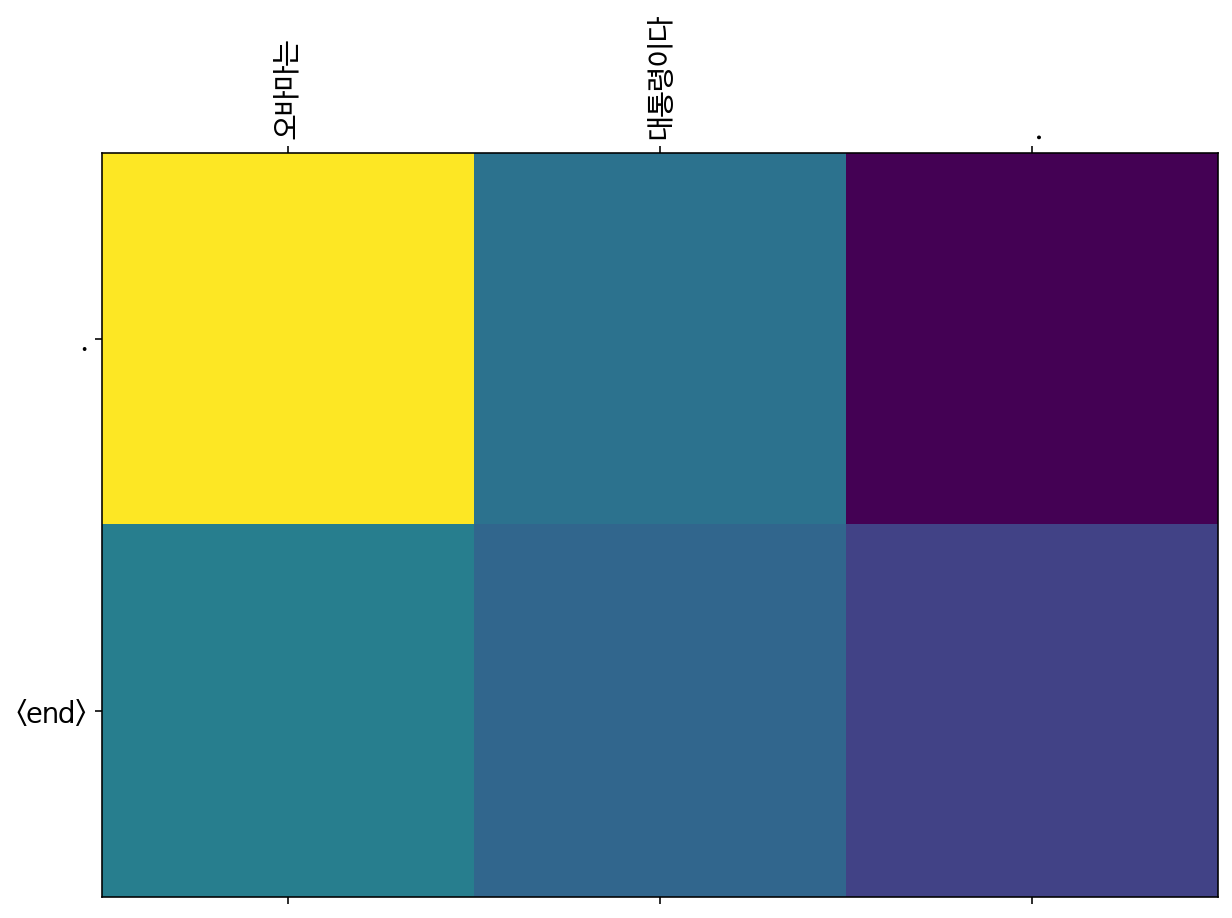

In [32]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: . <end> 


/tmp/ipykernel_48/164705771.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/164705771.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


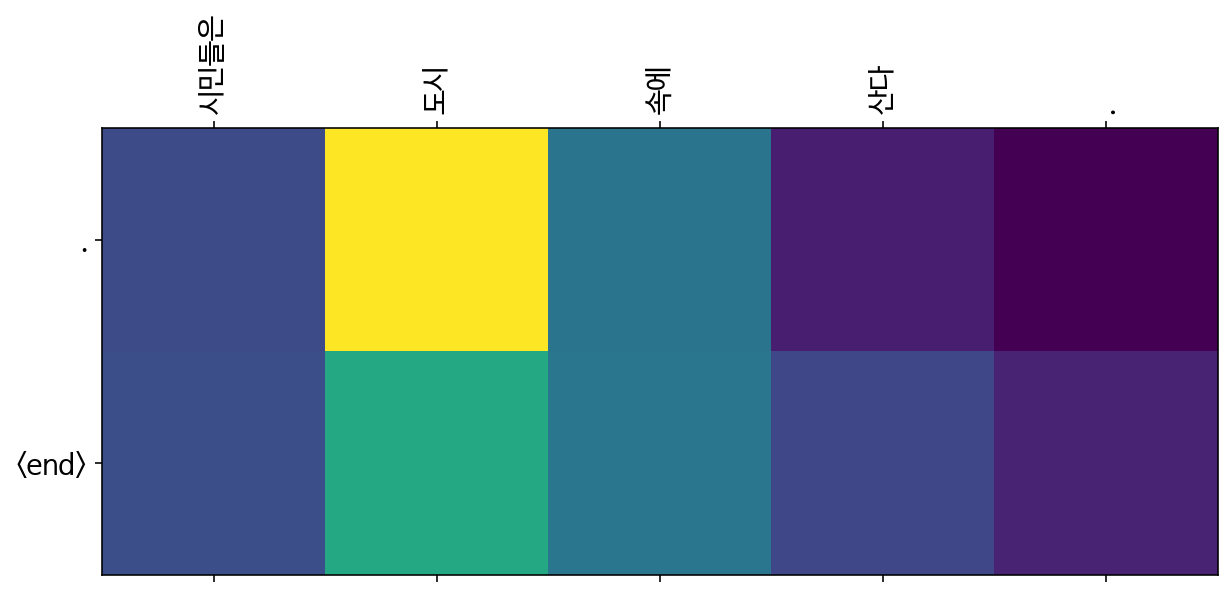

In [33]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: it s not going to be very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very 


/tmp/ipykernel_48/164705771.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/164705771.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


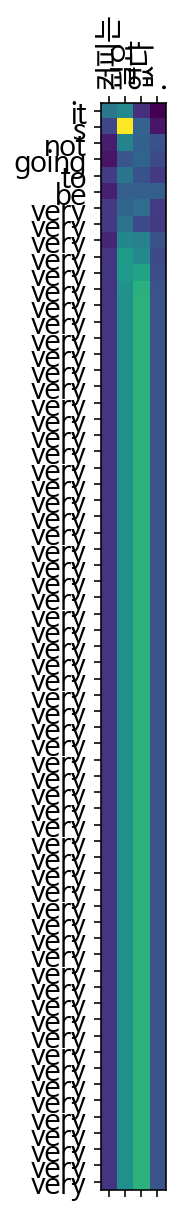

In [34]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: police said . <end> 


/tmp/ipykernel_48/164705771.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/164705771.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


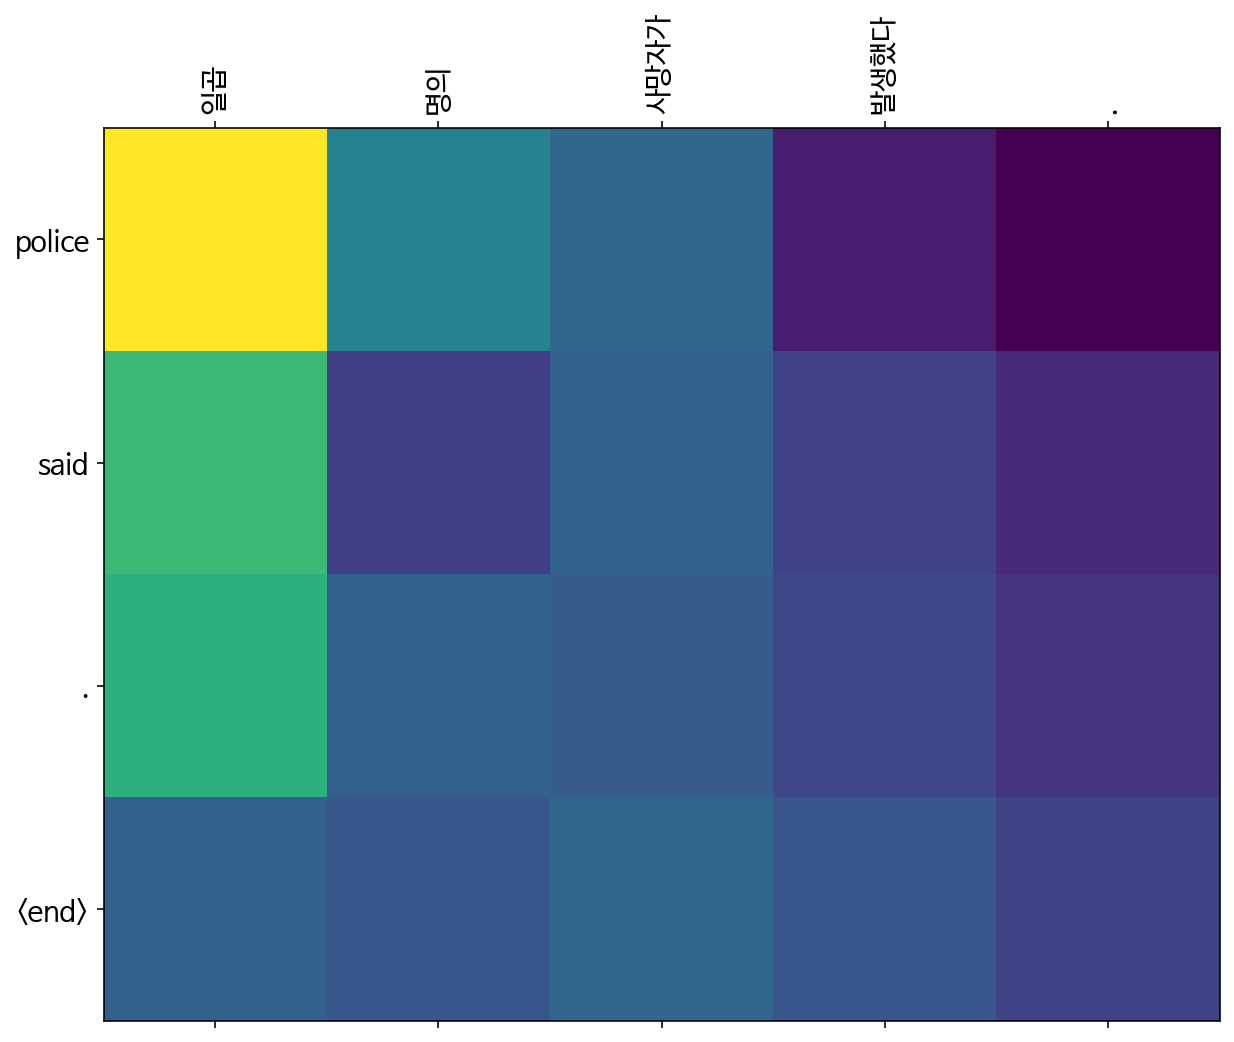

In [35]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

# 회고

- 한국어 토큰화는 잘 진행된 것으로 보이는데 모델 훈련 후 결과는 형편없다.  
- 한국어 데이터와 영문 데이터에 불필요하거나 잘못된 데이터들이 섞여있을 것이라 추측한다.
- 이 부분에서 데이터 정제와 분석이 중요하다는 것을 깨달았다. 다음 노드에서는 더 자세하게 살펴봐야겠다고 생각했다.
- loss 는 훈련하는 동안 조금씩 줄어들었다.
- Transformer 번역기 결과가 기대된다.

# 참고사이트

[참고깃허브](https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-08%5Dattention_based_seq2seq_translation.ipynb)